# Анализ тарифных планов сотового оператора

**Описание проекта**

Компания «N», федеральный оператор сотовой связи, предлагает сволим клиентам два тарифных плана: «Смарт» и «Ультра». Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов, которая содержит данные 500 пользователей «N». Необходиимо понять кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

**Задача**

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше, т.е. приносит больше денег (более маржинальный).

**Описание тарифов**
**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

**Примечание:**
- «N» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


## Изучение данных из файла

In [1]:
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from scipy import stats as st

Изучим первичную информацию о поведении пользователей, выгруженную в пяти датасетах

In [2]:
calls = pd.read_csv('/datasets/calls.csv', sep=',')  #содержит информацию о исходящих звонках

In [3]:
display(calls.tail())

,id,call_date,duration,user_id
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499
202606,1499_219,2018-12-14,19.62,1499


In [4]:
calls.info() # проверим информацию в датасете 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Пустых строк нет. Имена колонок названы стилистически корректно. Столбец `call_date` необходимо будет перевести в тип дата, а `duration` округлить до целых минут. Имеются нулевые значения длительности звонка. В вводных к задаче сказано, что нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

In [6]:
internet = pd.read_csv('/datasets/internet.csv', sep=',')  #содержит информацию об интернет трафике и сессиях пользователей

In [7]:
display(internet.tail())

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [8]:
internet.info() # проверим информацию в датасете 
internet['mb_used'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Пустых строк нет. Имена колонок названы стилистически корректно. Столбец `session_date` необходимо будет перевести в тип дата. Нужно не забыть при группировке pivot сгруппированные по столбцу `mb_used` и по месяцу данные перевести из Мб в Гб и округлить в большую сторону до Гб.

In [9]:
messages = pd.read_csv('/datasets/messages.csv', sep=',')   #содержит информацию о исходящих sms

In [10]:
display(messages.tail())

,id,message_date,user_id
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Пустых строк нет. Имена колонок названы стилистически корректно. Столбец `message_date` необходимо будет перевести в тип дата.

In [12]:
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')   #содержит информацию о тарифных планах

In [13]:
display(tariffs.tail())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [14]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

В таблице с Тарифами всего 2 строки. Т.к. оплата за интернет округляется компанией до Гб то в столбце `mb_per_month_included` необходимо значение перевести из Мб  в Гб

In [15]:
users = pd.read_csv('/datasets/users.csv', sep=',')     #содержит информацию об абонентах

In [16]:
display(users.tail())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом.
- city — город проживания пользователя
- tarif — название тарифного плана

Пустых строки в столбце `churn_date`. В водных была подсказка, если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Эти пропуски необходимо сохранить. Имена колонок названы стилистически корректно. Столбцы `reg_date` и `churn_date` необходимо будет перевести в тип дата.

Проверим строки на явные дубликаты и дубли уникальных номеров. 

In [18]:
print (users.duplicated().sum())
print (calls.duplicated().sum())
print (messages.duplicated().sum())
print (internet.duplicated().sum())

0
0
0
0


In [19]:
print(users['user_id'].nunique()) #проверим нет ли дублей по ID абонента
print(users['user_id'].count())
print(messages['id'].nunique()) #проверим нет ли дублей в уникальных номерах sms
print(messages['id'].count())
print(internet['id'].nunique()) #проверим нет ли дублей в уникальных номерах сессий интернета
print(internet['id'].count())

500
500
123036
123036
149396
149396


### Вывод

На этапе изучения данных была проведена проверка данных, названия колонок, наполнение столбцов, типы переменных, статистические данные датафрейма, а также наличие пустот и аномалий.

Данные находятся в 5 датасетах. Далее необходима будет склейка данных для проведегния полного анализа. 

Колонки названы корректно, в змеином стиле, нижний регистр, без пропусков. Корректировка не требуется.

Колонки имеют типы данных: float64(14), int64(3), object(3).
Значения дат во всех таблицах нужно перевести из строкого типа `object` в тип `datetime`. Т.к. тарификация помесячная, то необходимо выделить в отдельную колнку месяц, по которому в дальнейшем объединим столбцы. 
Ввиду того, что тарификация на обоих тарифах поминутная, то тип float64 переведем int с округлением в вверх.

**Описание данных**

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Предобработка данных

Преобразуем типы данных, добавим столбец месяц и выполним преобразования которые наметили в процессе первичного анализа данных.

In [20]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d') #преобразуем в тип datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['month_reg'] = users['reg_date'].dt.month.astype('int') #выделим отдельный столбец месяц и переведм в целочисленные значения
users['month_churn'] = users['churn_date'].dt.month
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      500 non-null    int64         
 1   age          500 non-null    int64         
 2   churn_date   38 non-null     datetime64[ns]
 3   city         500 non-null    object        
 4   first_name   500 non-null    object        
 5   last_name    500 non-null    object        
 6   reg_date     500 non-null    datetime64[ns]
 7   tariff       500 non-null    object        
 8   month_reg    500 non-null    int64         
 9   month_churn  38 non-null     float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 39.2+ KB


Т.к. для склейки нам нужен только номер месяца из 2018 года, то сразу выделим и преобразуем эти данные в отдельном столбце без изменения типа столбца с датой. Проведем эту операцию на всех таблицах.

In [21]:
calls['month'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d').dt.month
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
 4   month      202607 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.7+ MB


In [22]:
messages['month'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d').dt.month
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
 3   month         123036 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.8+ MB


In [23]:
internet['month'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d').dt.month
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
 5   month         149396 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 6.8+ MB


Т.к. звонки оцениваются по минутно, то в столбце `duration` округлим значения до целых минут.

In [24]:
print (calls['duration'].head())

0     0.00
1     0.00
2     2.85
3    13.80
4     5.18
Name: duration, dtype: float64


In [25]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
print (calls.head())

       id   call_date  duration  user_id  month
0  1000_0  2018-07-25         0     1000      7
1  1000_1  2018-08-17         0     1000      8
2  1000_2  2018-06-11         3     1000      6
3  1000_3  2018-09-21        14     1000      9
4  1000_4  2018-12-15         6     1000     12


Т.к. тарификация в обоих тарифах погигабайтная, то переведем в датасете `tariffs` значения в столбце `mb_per_month_included` из Мб в ГБ.

In [26]:
print (tariffs['mb_per_month_included'])

0    15360
1    30720
Name: mb_per_month_included, dtype: int64


In [27]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype('int')
tariffs = tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'})
print (tariffs['gb_per_month_included'])

0    15
1    30
Name: gb_per_month_included, dtype: int64


Чтобы отсеять не важную информацию сгруппируем все таблицы по столбцам `user_id` и `month`

In [28]:
calls_pivot = calls.pivot_table(index=['month', 'user_id'], values='duration', aggfunc='sum').reset_index()
calls_pivot

,month,user_id,duration
0,1,1005,95
1,1,1032,380
2,1,1045,9
3,1,1055,551
4,1,1071,194
...,...,...,...
3169,12,1494,418
3170,12,1495,1031
3171,12,1496,518
3172,12,1497,545


In [29]:
messages_pivot = messages.pivot_table(index=['month', 'user_id'], values='id', aggfunc='count').reset_index()
messages_pivot

,month,user_id,id
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


Переименуем столбец `id` в `messages`

In [30]:
messages_pivot = messages_pivot.rename(columns = {'id': 'messages'})
messages_pivot

,month,user_id,messages
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


Сгруппируем данные датасета `internet` по месяцу и переведем Мб в Гб

In [31]:
internet_pivot = internet.pivot_table(index=['month', 'user_id'], values='mb_used', aggfunc='sum').reset_index()
internet_pivot['gb_used'] = np.ceil(internet_pivot['mb_used']/1024).astype('int') # переведем в Гб
internet_pivot

,month,user_id,mb_used,gb_used
0,1,1005,2727.97,3
1,1,1032,24127.69,24
2,1,1045,2346.71,3
3,1,1055,17090.88,17
4,1,1071,15604.34,16
...,...,...,...,...
3198,12,1494,17621.21,18
3199,12,1495,23426.76,23
3200,12,1496,20736.15,21
3201,12,1497,19918.60,20


In [32]:
internet_pivot = internet_pivot.drop('mb_used', 1) #удалим столбец с Мб
internet_pivot

,month,user_id,gb_used
0,1,1005,3
1,1,1032,24
2,1,1045,3
3,1,1055,17
4,1,1071,16
...,...,...,...
3198,12,1494,18
3199,12,1495,23
3200,12,1496,21
3201,12,1497,20


Приведем все данные в единую таблицу. Для этого склеим данные по столбцам `user_id` и `month`.

In [33]:
df = (calls_pivot
      .merge(messages_pivot, on=['user_id', 'month'], how='outer')    #объединение если есть данные хотя бы в одной из таблиц
      .merge(internet_pivot, on=['user_id', 'month'], how='outer')    #объединение если есть данные хотя бы в одной из таблиц
      .merge(users, on='user_id', how='left')                         #в итоговую таблицу будут включены id из 1
     )
df.head()

,month,user_id,duration,messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month_churn
0,1,1005,95.0,7.0,3.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1,NaN
1,1,1032,380.0,38.0,24.0,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,1,NaN
2,1,1045,9.0,5.0,3.0,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,1,NaN
3,1,1055,551.0,30.0,17.0,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,1,NaN
4,1,1071,194.0,16.0,16.0,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,1,8.0


Удалим столбцы, которые не пригодятся нам в анализе

In [34]:
df_clear = df.drop(['churn_date','first_name','last_name','reg_date'], axis=1)
df_clear.head()

,month,user_id,duration,messages,gb_used,age,city,tariff,month_reg,month_churn
0,1,1005,95.0,7.0,3.0,67,Набережные Челны,smart,1,NaN
1,1,1032,380.0,38.0,24.0,31,Ульяновск,smart,1,NaN
2,1,1045,9.0,5.0,3.0,48,Улан-Удэ,smart,1,NaN
3,1,1055,551.0,30.0,17.0,39,Казань,smart,1,NaN
4,1,1071,194.0,16.0,16.0,20,Омск,smart,1,8.0


Заменим пропуск в столбцах `duration`, `messages`, `gb_used` на нулевые значения. Пропуски означают, что абонент не воспользовался услугами. 

In [35]:
df_clear.isna().sum()  #посчитаем количество пропусков

month             0
user_id           0
duration         40
messages        497
gb_used          11
age               0
city              0
tariff            0
month_reg         0
month_churn    3027
dtype: int64

In [36]:
df_clear[['duration', 'messages' , 'gb_used']] = df_clear[['duration', 'messages' , 'gb_used']].fillna(0)
df_clear.isna().sum()

month             0
user_id           0
duration          0
messages          0
gb_used           0
age               0
city              0
tariff            0
month_reg         0
month_churn    3027
dtype: int64

In [37]:
df_clear[['duration', 'messages' , 'gb_used']] = df_clear[['duration', 'messages' , 'gb_used']].astype('int')

Посчитаем помесячную выручку с каждого пользователя. Создадим функцию, которая посчитает по каждому тарифу доход с учетом его особенностей.

In [38]:
display (tariffs)

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


Создадим переменные для значений параметров тарифа из таблицы `tariffs`

In [39]:
fee_smart = int(tariffs.query('tariff_name == "smart"')['rub_monthly_fee'])
fee_ultra = int(tariffs.query('tariff_name == "ultra"')['rub_monthly_fee'])
minutes_smart = int(tariffs.query('tariff_name == "smart"')['minutes_included'])
minutes_ultra = int(tariffs.query('tariff_name == "ultra"')['minutes_included'])
messages_smart = int(tariffs.query('tariff_name == "smart"')['messages_included'])
messages_ultra  =  int(tariffs.query('tariff_name == "ultra"')['messages_included'])
gb_per_month_smart  = int(tariffs.query('tariff_name == "smart"')['gb_per_month_included'])
gb_per_month_ultra = int(tariffs.query('tariff_name == "ultra"')['gb_per_month_included'])
rub_sms_smart = int(tariffs.query('tariff_name == "smart"')['rub_per_message'])
rub_sms_ultra = int(tariffs.query('tariff_name == "ultra"')['rub_per_message'])
rub_min_smart = int(tariffs.query('tariff_name == "smart"')['rub_per_minute'])
rub_min_ultra = int(tariffs.query('tariff_name == "ultra"')['rub_per_minute'])
rub_per_gb_smart = int(tariffs.query('tariff_name == "smart"')['rub_per_gb'])
rub_per_gb_ultra = int(tariffs.query('tariff_name == "ultra"')['rub_per_gb'])

In [40]:
a = (fee_smart, fee_ultra, minutes_smart, minutes_ultra, messages_smart, messages_ultra, gb_per_month_smart, gb_per_month_ultra, rub_sms_smart, rub_sms_ultra, rub_min_smart, rub_min_ultra, rub_per_gb_smart, rub_per_gb_ultra)
print (a)

(550, 1950, 500, 3000, 50, 1000, 15, 30, 3, 1, 3, 1, 200, 150)


In [41]:
def revenue(row):  
    if row['tariff'] == 'smart':
        if row['duration']<= minutes_smart:
            a = 0
        else:
            a = (row['duration'] - minutes_smart) * rub_min_smart
        if row['messages']<= messages_smart:
            b = 0
        else:
            b = (row['messages'] - messages_smart) * rub_sms_smart
        if row['gb_used'] <= gb_per_month_smart:
            c = 0
        else:
            c = (row['gb_used']- gb_per_month_smart) * rub_per_gb_smart
        return fee_smart+a+b+c
    if row['tariff'] == 'ultra':
        if row['duration']<= minutes_ultra:
            a = 0
        else:
            a = row['duration'] - minutes_ultra
        if row['messages'] <= messages_ultra:
            b = 0
        else:
            b = row['messages'] - messages_ultra
        if row['gb_used']<= gb_per_month_ultra:
            c = 0
        else:
            c = (row['gb_used'] - gb_per_month_ultra) * rub_per_gb_ultra
        return fee_ultra+a+b+c       

df_clear['revenue'] = df_clear.apply(revenue, axis=1)  #применим функцию к датасету и запишем столбец revenue (пер. доход)
df_clear.head()

,month,user_id,duration,messages,gb_used,age,city,tariff,month_reg,month_churn,revenue
0,1,1005,95,7,3,67,Набережные Челны,smart,1,NaN,550
1,1,1032,380,38,24,31,Ульяновск,smart,1,NaN,2350
2,1,1045,9,5,3,48,Улан-Удэ,smart,1,NaN,550
3,1,1055,551,30,17,39,Казань,smart,1,NaN,1103
4,1,1071,194,16,16,20,Омск,smart,1,8.0,750


## Исследовательский анализ данных

Проанализируем данные. Опишем поведение клиентов оператора, исходя из выборки `df_clear`

Посчитаем минимальное и максимальное значение, а также среднее количество, дисперсию и стандартное отклонение по столбцу выручка по каждому тарифу в отдельности.

In [42]:
df_clear_tariff = df_clear.pivot_table(index='tariff', values='revenue', aggfunc= ['min', 'max', 'mean', 'median', 'var','std'])
print (df_clear_tariff)

           min     max         mean  median            var         std
       revenue revenue      revenue revenue        revenue     revenue
tariff                                                                
smart      550    6770  1289.973531    1023  669785.708006  818.404367
ultra     1950    4800  2070.152284    1950  141516.745079  376.187114


Стандартное отклонение и значение медианы показывает, что несмотря на то, что абонентская плата (далее - АП) на тарифе Smart ниже, абоненты тратят значительно больше и приносят компании больше денег. По медиане и средней выручке на тарифе Ultra видим, что в целом абоненты тратят сумму равную абонентской плате и стараются не выходить за рамки АП. Стандартное отклонение не значительное. 

Построим гистограммы и посмотрим распределение

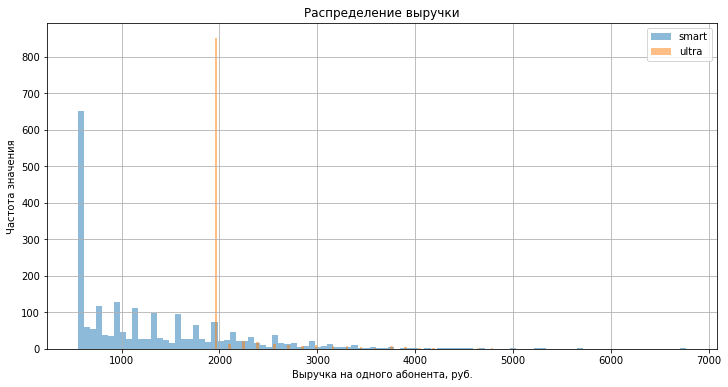

In [43]:
fig, ax = plt.subplots()
df_clear.query('tariff == "smart"').plot(y='revenue', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'smart', figsize=(12,6), grid=True)
df_clear.query('tariff == "ultra"').plot(y='revenue', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'ultra', grid=True)
ax.set_xlabel('Выручка на одного абонента, руб.')
ax.set_ylabel('Частота значения')
ax.set_title('Распределение выручки')
plt.show()

<AxesSubplot:>

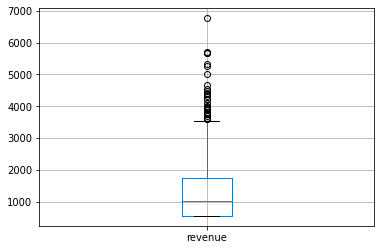

In [44]:
df_clear.query('tariff == "smart"').boxplot(column=['revenue']) # построим диаграмму размаха для тарифа Смарт

График подтверждает гипотезу, что значительное количество абонентов тратит больше установленной АП (много выбросов за пределами усов)

<AxesSubplot:>

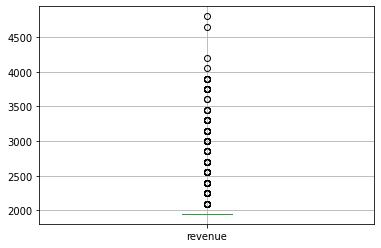

In [45]:
df_clear.query('tariff == "ultra"').boxplot(column=['revenue']) 

На графике Ультра видим незначительное количество выбросов. Ящик усов совпадает с медианой. 

In [46]:
display (tariffs)

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


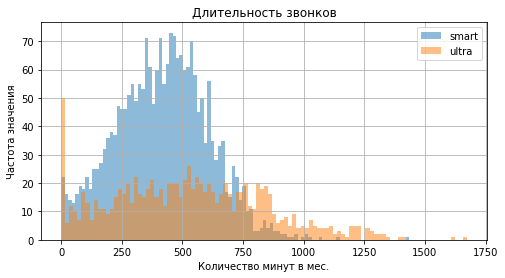

In [47]:
fig, ax = plt.subplots()
df_clear.query('tariff == "smart"').plot(y='duration', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'smart', figsize=(8,4), grid=True)
df_clear.query('tariff == "ultra"').plot(y='duration', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'ultra', grid=True)
ax.set_xlabel('Количество минут в мес.')
ax.set_ylabel('Частота значения')
ax.set_title('Длительность звонков')
plt.show()

Значительное количество абонентов тарифного плана Смарт выговаривают больше положенного пакета минут (500 минут). Напротив, абоненты более дорогого тарифа Ультра не выговаривают бесплатное количество минут из пакета (3000 мин.). 

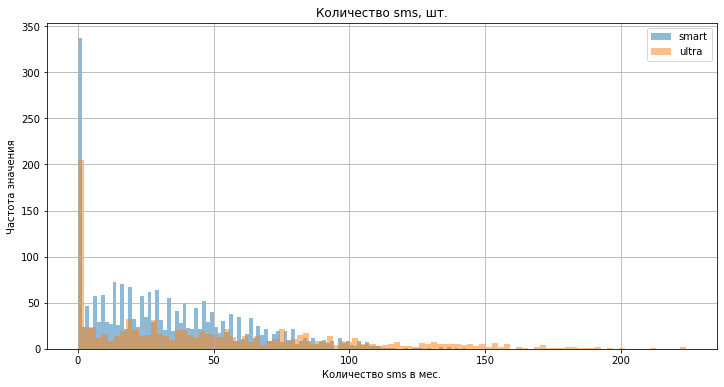

In [48]:
fig, ax = plt.subplots()
df_clear.query('tariff == "smart"').plot(y='messages', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'smart', figsize=(12,6), grid=True)
df_clear.query('tariff == "ultra"').plot(y='messages', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'ultra', grid=True)
ax.set_xlabel('Количество sms в мес.')
ax.set_ylabel('Частота значения')
ax.set_title('Количество sms, шт.')
plt.show()

График показывает, что значительное количество абонентов не отправляет sms. Чтобы рассмотреть абонентов, отправляющих сообщения, более детально построим график без 0-х значений.

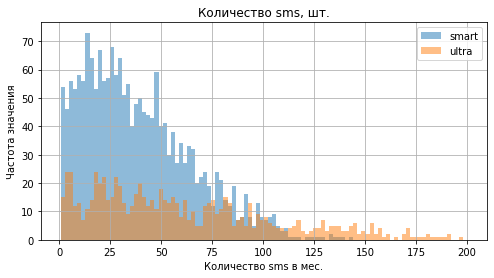

<Figure size 7200x7200 with 0 Axes>

In [49]:
fig, ax = plt.subplots()
df_clear.query('tariff == "smart"').plot(y='messages', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'smart', figsize=(8,4), grid=True, range=(1,200))
df_clear.query('tariff == "ultra"').plot(y='messages', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'ultra', grid=True, range=(1,200))
fig = plt.figure(figsize=(100, 100))
ax.set_xlabel('Количество sms в мес.')
ax.set_ylabel('Частота значения')
ax.set_title('Количество sms, шт.')
plt.show()

Значительное количество абонентов тарифного плана Смарт стараются расходовать положенный пакет в 50 sms. Многоим этого пакета не хватает, поэтому пользуются платными сообщениями. Напротив, абоненты более дорогого тарифа Ультра не выговаривают бесплатное количество sms из пакета (1000 шт.). 

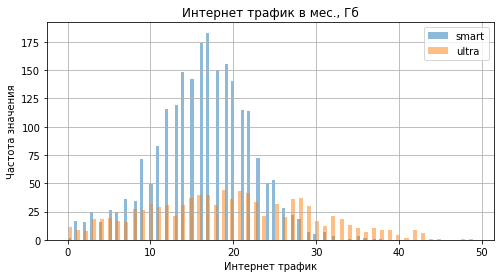

In [50]:
fig, ax = plt.subplots()
df_clear.query('tariff == "smart"').plot(y='gb_used', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'smart', figsize=(8,4), grid=True)
df_clear.query('tariff == "ultra"').plot(y='gb_used', kind='hist', bins=100, alpha=0.5, ax=ax, label = 'ultra', grid=True)
ax.set_xlabel('Интернет трафик')
ax.set_ylabel('Частота значения')
ax.set_title('Интернет трафик в мес., Гб')
plt.show()

Значительное количество абонентов тарифного плана Смарт стабильного много пользуются интернетом. Включенных в пакет 15Гб явно не достаточно, приходиться оплачивать интернет погигабайтно. Болшинство абонентов ТП Ультра тратят около 20 Гб. График распределен нормально, за пределы 50Гб абоненты выборки не выходили. 

По итогам оценки расходов пользователей можно сделать вывод, что необходим промежуточный тариф со средней ценой, который будет включать в себя увеличенные пакеты минут, смс и интернета. Большую часть пользователей ТП Smart можно будет перевети на него. 

## Проверка гипотез

Проверим 2 гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    
В качестве выборок по тарифам для проверки гипотезы используем склеяную таблицу `df_clear`. Проверим достаточное ли количество значений для оценки. 


In [51]:
array_ultra = df_clear.query('tariff == "ultra"')['revenue']     #выделим массив выборки абонентов ТП Ультра
print (f'количество значений по ТП Ультра: {len(array_ultra)}')
array_smart = df_clear.query('tariff == "smart"')['revenue']     #выделим массив выборки абонентов ТП Смарт
print (f'количество значений по ТП Смарт: {len(array_smart)}')

количество значений по ТП Ультра: 985
количество значений по ТП Смарт: 2229


Сформулируем нулевую и альтернативные гипотезы для первой гипотезы. 
* H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы.
* H₁ - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Это 2-хсторонняя гипотеза.

Воспользуемся методом t-тест для сравнения 2х выборок. Как мы выяснили в предыдущем разделе, дисперсии выборок не равны.

In [52]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем 0-ю гипотезу в сторону альтернативной.

In [53]:
results = st.ttest_ind(
    array_ultra, 
    array_smart,
    equal_var = False     #разные по размеру выборки, дисперсия сильно отличается
)

In [54]:
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Результат теста дает понять, что скорее всего предположение, что средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы НЕ верное. Слишком низка вероятность того, что средние доходы по ним совпадут. Вероятнее всего, что доходы по этим тарифам будут отличаться. 

**Сформулируем нулевую и альтернативные гипотезы для второй гипотезы.**
* H₀ - средняя выручка пользователей из Москвы совпадает с выручкой пользователей из других регионов.
* H₁ - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Это 2-хсторонняя гипотеза.

In [55]:
print (df_clear['city'].unique()) #проверим города на дубликаты

['Набережные Челны' 'Ульяновск' 'Улан-Удэ' 'Казань' 'Омск' 'Чита'
 'Краснодар' 'Санкт-Петербург' 'Красноярск' 'Архангельск' 'Ставрополь'
 'Кострома' 'Волгоград' 'Тамбов' 'Москва' 'Киров' 'Ростов-на-Дону' 'Уфа'
 'Вологда' 'Пенза' 'Магнитогорск' 'Иркутск' 'Орёл' 'Астрахань' 'Подольск'
 'Ярославль' 'Новокузнецк' 'Нижний Тагил' 'Мурманск' 'Самара' 'Воронеж'
 'Пермь' 'Саранск' 'Новосибирск' 'Владивосток' 'Нижний Новгород'
 'Новороссийск' 'Брянск' 'Челябинск' 'Калининград' 'Барнаул' 'Якутск'
 'Тольятти' 'Курган' 'Томск' 'Балашиха' 'Саратов' 'Петрозаводск' 'Тюмень'
 'Курск' 'Тула' 'Сочи' 'Оренбург' 'Смоленск' 'Хабаровск' 'Рязань'
 'Махачкала' 'Тверь' 'Ижевск' 'Чебоксары' 'Белгород' 'Череповец'
 'Стерлитамак' 'Владимир' 'Волжский' 'Калуга' 'Екатеринбург' 'Севастополь'
 'Нижневартовск' 'Грозный' 'Владикавказ' 'Химки' 'Сургут' 'Липецк'
 'Кемерово' 'Иваново']


In [56]:
array_msk = df_clear.query('city == "Москва"')['revenue']      #выделим массив выборки абонентов г.Москва
print (f'количество значений по г.Москва: {len(array_msk)}')
array_region = df_clear.query('city != "Москва"')['revenue']    #выделим массив выборки абонентов регионов
print (f'количество значений по регионам: {len(array_region)}')

количество значений по г.Москва: 611
количество значений по регионам: 2603


In [57]:
results = st.ttest_ind(
    array_msk, 
    array_region,
    equal_var = False     #выборки разные по размеру
)

In [58]:
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


По итогам теста видим, что скорее всего, верно предположение, что средняя выручка пользователей из Москвы совпадает с выручкой пользователей из других регионов.

## Общий вывод

На входе мы получили данные по 500 пользователям «Мегалайна». 

**В выборке значения были распределены следующим образом.**

**По городам:**
* количество пользователей по г.Москва: 611
* количество пользователей по регионам: 2603

**По тарифам:**
* количество абонентов ТП Ультра: 985
* количество абонентов ТП Смарт: 2229

**Проведя предварительный анализ тарифов можно сделать следующие выводы:**

Стандартное отклонение и значение медианы показывает, что несмотря на то, что абонентская плата (далее - АП) на тарифе Smart ниже, абоненты тратят значительно больше чем заложено в цену тарифа, а значить приносят компании больше денег. 
По медиане и средней выручке на тарифе Ultra видим, что в целом абоненты тратят сумму равную абонентской плате и стараются не выходить за рамки АП. Стандартное отклонение не значительное. По этим абонентам компания получает высокий и стабильный доход, т.к. заложеные в себестоимость пакеты практически не расходуются. Это подтверждает и анализ графиков распределения по тарифам звонков, sms и интернет-трафика. 

**Анализ графиков позволяет сделать следующие выводы:**
1. Значительное количество абонентов ТП Смарт тратит больше установленной АП. И наоборот, абоненты ТП Ультра в целом не выбирают бесплатные пакеты. 
2. Значительное количество абонентов тарифного плана Смарт выговаривают больше положенного пакета в 500 минут. Напротив, абоненты более дорогого тарифа Ультра не выговаривают бесплатное количество минут из пакета (3000 мин.).
3. График распределения показал, что большое количество абонентов обоих тарифов не отправляет sms. 
4. Значительное количество абонентов тарифного плана Смарт стараются расходовать положенный пакет в 50 sms. Многоим этого пакета не хватает, поэтому пользуются платными сообщениями. Напротив, абоненты более дорогого тарифа Ультра не выговаривают бесплатное количество sms из пакета (1000 шт.). 
5. Значительное количество абонентов тарифного плана Смарт стабильного много пользуются интернетом. Включенных в пакет 15Гб явно не достаточно, приходиться оплачивать интернет погигабайтно. Большинство абонентов ТП Ультра тратят около 20 Гб. при пакете в 30 Гб.

**Проверили 2 гипотезы:**
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Результаты 1-го t-теста показали, что, скорее всего, верно предположение, что **средняя выручка пользователей тарифов «Ультра» и «Смарт» будут отличаться.**

Результаты 2-го t-теста показали, что, скорее всего, верно предположение, что **средняя выручка пользователей из Москвы совпадает с выручкой пользователей из других регионов.**

**По итогам оценки расходов пользователей можно сделать вывод, что необходим промежуточный тариф со средней ценой (выше АП "Смарт" и ниже АП "Ультра"), который будет включать в себя увеличенные пакеты минут, смс и интернета. Большую часть пользователей ТП Smart можно будет перевети на него. Тогда доходы компании вырастут. Важно сохранять баланс предложения (пакетов) и цены. Тогда компания удовлетворит запросы рынка по разным сегментам пользователей и получит бОльший доход.**